# k-Nearest Neighbours | Algorithm From Scratch


##### 1. Background
k-Neatest Neighbours (kNN) is a popular algorithm that can be used for both classification and regression models. This algorithm assumes the following:
- Assumption One: The distribution of our data is assumed to be Uniform
- Assumption Two: Similar datapoints have the same class - i.e. points that lie close to one another in n-dimensional space have the same class

This algorithm works by calculating the distance between points to verify which points are in close proximity to another. The 'k'-th number of closest points are then categorized as the 'k-nearest-neighbours' (Note: 'k' is specified by the end-user). 

For classification, the predicted target is the mode of the k-nearest-neighbours' targets. For regression, the predicted target is the mean of the k-nearest-neighbours' targets.


##### 2. Algorithm Steps
- Step 1: Specify 'k'
- Step 2: Calculate the distance between the test point and all training points
- Step 3: Arrange calculated distances in ascending order 
- Step 4: Select the first k-th number of points (points with the smallest distances)
- Step 5: If Classification - Calculate target mode for the k-th number of points, Else - Calculate the target mean for the k-th number of points
- Step 6: If Classification - Return mode target, Else - Return mean target

##### 3. Loading Data
For this notebook, we will be using the classic Iris dataset for classification

In [1]:
#import libraries
import numpy as np
import pandas as pd
import statistics 

In [2]:
#import data
data = pd.read_csv('iris.csv')

#displaying first five rows
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


The species (target) column is in string format. We will need to encode the target column. Additionally, the features have different measurement ranges. We will need to scale each feature such that they have similar ranges - This will be done using the MinMaxScaler function from Sklearn. This will scale the data down to values between 0 and 1. 

#### Reasoning:
When calculating distances, it is important to ensure that your data has similar scales. If not, variables that have a large data range may result in larger distance differences, which can be misleading. Additionally, these features are weighted as having a higher importance.

In [3]:
#importing preprocessing tools
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
scaler = MinMaxScaler()

#encoding target
data.species = encoder.fit_transform(data.species)

We will need to first split our data into training and test sets before scaling. Scaling prior to the data split will result in data leakage. The training min and max values used for scaling will be used to transform the test data values to prevent data leakage. 

In [4]:
#splitting data into train and test
from sklearn.model_selection import train_test_split

X = data[data.columns[:-1]]
y = data.species

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=20)

In [5]:
#scaling features to compute distances
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#reset y index to match X_train & X_test
y_train.index = X_train.index
y_test.index = X_test.index

##### 4. Writing Algorithm Functions

In [6]:
#function to calculate the euclidian distance

def euclidian_distance(X_train, X_test):
    #create empty list to store all distances per feature
    distances = []
    
    #loop through each X_test datapoint and calculate the distance between datapoint and X_train points
    for i in range(len(X_test)):
        obs = X_test.loc[i]
        dist_sq_sum = 0
        
        for col in (X_train.columns):
            #calculate squared distance between X_test point and all of X_train points per feature
            dist_sq_sum += ((X_train[col] - obs[col])**2)
            
        #append distance to list    
        distances.append(np.sqrt(dist_sq_sum))
    return distances

In [7]:
#function to predict values

def predict(X_train, X_test, y_train, k):
    #calculate distances and store in a dataframe
    distances = pd.DataFrame(euclidian_distance(X_train, X_test))
    distances.index = range(len(distances))
    distances = distances.transpose()
    
    #calculate mode target for the nearest neighbours
    mode = []
    for col in distances.columns:
        neighbours = distances[col].sort_values().index[0:k]
        targets = []
        for neighbour in neighbours:
            targets.append(y_train.loc[neighbour])
        mode.append(statistics.mode(targets))
    mode = pd.Series(mode)
    return mode

##### 5. Testing Algorithm

In [8]:
#predict classification for X_test with 5 nearest neighbours
y_hat = predict(X_train, X_test, y_train, 3)

In [9]:
#placing y_hat and y_test in a dataframe for easy comparison
y_results = pd.DataFrame([y_hat,y_test]).transpose()
y_results.columns = ['y_hat', 'y_test']

In [10]:
y_results.head()

,y_hat,y_test
0,0,0
1,1,1
2,1,1
3,2,2
4,1,1


In [11]:
#displaying incorrectly predicted values
y_results[y_results.y_hat != y_results.y_test]

,y_hat,y_test
12,1,2
29,1,2


From the above, the kNN algorithm works quite well on the data with 2/30 (6.67%) misclassifications.

#### 6. Demonstration in 3-D Space

In [32]:
#create a random matrix with uniform distribution
np.random.seed(0)
random_matrix = pd.DataFrame(np.random.uniform(0,1, size=(50,3)))

#test point
pt = [0.5,0.6,0.8]
pt = pd.DataFrame(pt).transpose()

In [33]:
#import libaries for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#get 3 closest neighbours
dist = pd.DataFrame(euclidian_distance(random_matrix, pt)).transpose().sort_values(0)
knn_index = dist.index[0:3]
knn = pd.DataFrame()

kNN = []
for i in range(3):
    kNN.append(random_matrix.loc[knn_index[i]].to_list())
    
knn = knn.append(kNN)

#drop neighbors from random_matrix
random_matrix.drop(random_matrix.index[knn_index], inplace=True)

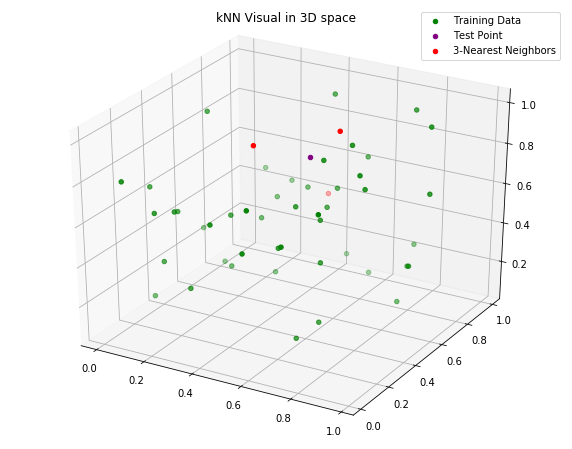

In [55]:
#plot graph
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(random_matrix[0], random_matrix[1], random_matrix[2], color='green')
ax.scatter(pt[0], pt[1], pt[2], color='purple')
ax.scatter(knn[0], knn[1], knn[2], color='red')
ax.legend(('Training Data', 'Test Point', '3-Nearest Neighbors'))
ax.set_title('kNN Visual in 3D space', pad=20);

The plot above demonstrates the nearest neighbours to our test point. The nearest neighbor is calculated using the euclidian distance. The mode of the targets for the red points will be predicted as the target for our test point (in purple).